In [1]:
import os
import pathlib
from typing import List
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from tqdm.auto import tqdm
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from flexitext import flexitext
import seaborn as sns
# import plotly.graph_objs as go
# from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
%load_ext autoreload
%autoreload 2

from helper_functions import epa_taiwan_data_pipeline, visualization

In [3]:
root_dir = pathlib.Path(os.getcwd()).parent
data_dir = root_dir / "data"

In [4]:
seed = 420
# Set the seed for general torch operations
torch.manual_seed(seed)
# Set the seed for CUDA torch operations (ones that happen on the GPU)
torch.cuda.manual_seed(seed)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data Loading

In [5]:
root_dir = pathlib.Path(os.getcwd()).parent
raw_data_dir = root_dir / "data/0_raw"
processed_data_dir = root_dir / "data/1_processed"
experiment_dir = root_dir / "experiment"

In [6]:
year = 2018
site_name = "Banqiao"
columns = ["SiteEngName","PM2.5","AMB_TEMP","CH4",'CO',"NMHC","read_time"]

# import data
pm25_df = epa_taiwan_data_pipeline.import_epa_data(site_name=site_name, year=year)[columns]

# basic preprocessing
pm25_df = epa_taiwan_data_pipeline.standardize_df(pm25_df)

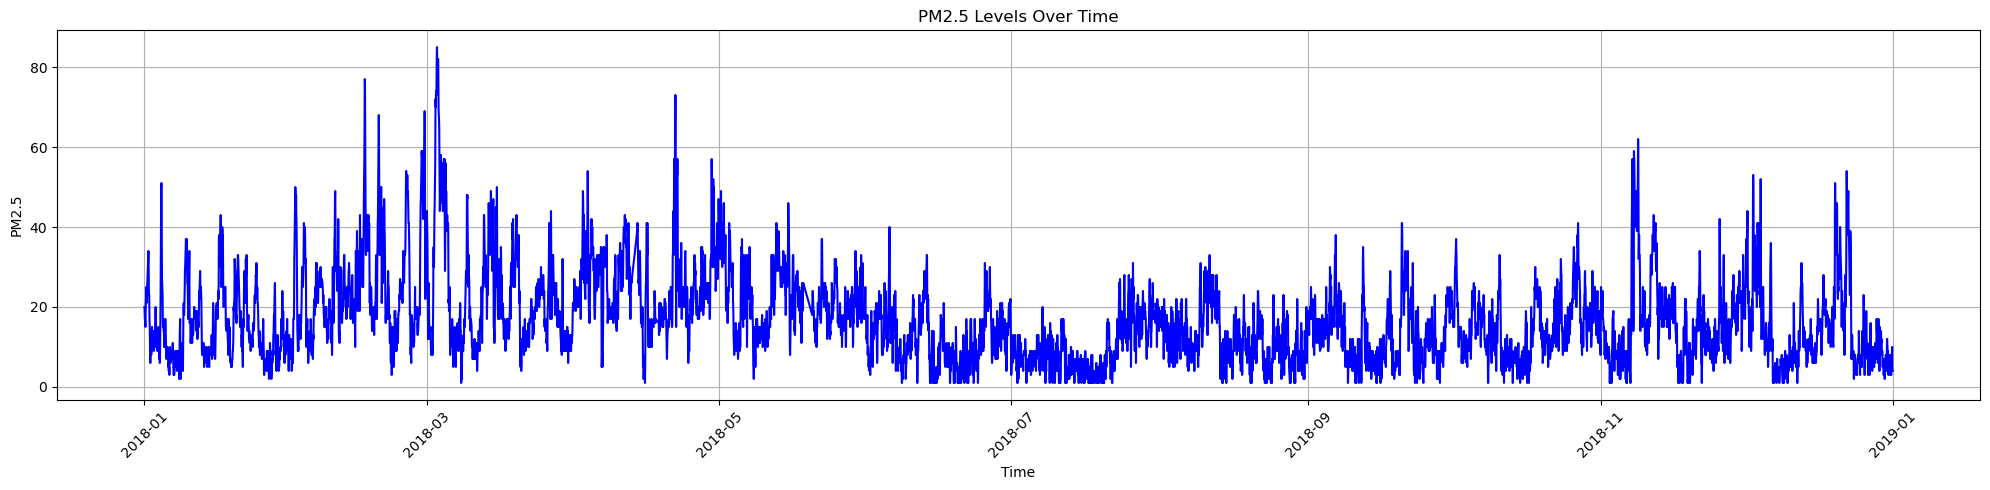

In [7]:
fig, ax = plt.subplots(figsize = (20,5))

ax.plot(
    pm25_df['read_time'],
    pm25_df['pm2.5'],
    # marker='o',
    linestyle='-',
    color='b'
    )
plt.title('PM2.5 Levels Over Time')
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Training

## Define Training Dataset

In [7]:
train_split = 0.6

train_data = pm25_df.iloc[:int(len(pm25_df)*train_split),:]
print(f"All data length:{len(pm25_df)} \nTrain data length:{len(train_data)}")
train_data.tail()

All data length:8760 
Train data length:5256


,siteengname,pm2.5,amb_temp,ch4,co,nmhc,read_time
399077,Banqiao,11.0,31.4,1.8,0.41,0.13,2018-08-07 19:00:00
399153,Banqiao,11.0,30.8,1.8,0.35,0.10,2018-08-07 20:00:00
399229,Banqiao,10.0,30.4,1.8,0.31,0.09,2018-08-07 21:00:00
399305,Banqiao,8.0,30.2,1.8,0.30,0.08,2018-08-07 22:00:00
399381,Banqiao,9.0,29.9,1.8,0.23,0.06,2018-08-07 23:00:00


In [9]:
# min_pm = train_data['pm25'].min()
# max_pm = train_data['pm25'].max()

# print(f"PM2.5 Minimum: {min_pm}\nPM2.5 Minimum: {max_pm}")

In [8]:
def min_max_df_norm(
    df:pd.DataFrame,
    target:str='pm2.5',
    cols:List=['pm2.5', 'amb_temp', 'ch4', 'co', 'nmhc']
    ) -> pd.DataFrame:
    """do a normalization to a dataframe

    Args:
        df (pd.DataFrame): the dataframe to be normalized
        target (str, optional): the target to be predicted later. Defaults to 'pm2.5'.
        cols (List, optional): columns that will be normalized. Defaults to ['pm2.5', 'amb_temp', 'ch4', 'co', 'nmhc'].

    Returns:
        Tuple[pd.DataFrame, float, float]: return the normalized df and min and max value of the target
    """
    for column in cols:
        normalized_column_name = column + '_normalized'
        df[normalized_column_name] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())
        max_column_name = column + '_max'
        df[max_column_name] = df[column].max()
        min_column_name = column + '_min'
        df[min_column_name] = df[column].min()

    return df

In [9]:
train_data = min_max_df_norm(train_data)

In [10]:
class MarketDataset(Dataset):
    def __init__(self, data, history_len):
        self.data = data
        self.history_len = history_len
        
    def __len__(self):
        self.len = len(self.data) - self.history_len  
        return self.len
    
    def __getitem__(self, index):
        # x_cols = ['pm2.5_normalized', 'amb_temp_normalized', 'ch4_normalized', 'co_normalized', 'nmhc_normalized']
        x_cols = ['pm2.5_normalized']
        y_cols = ['pm2.5_normalized']
        x = self.data.iloc[index: index+self.history_len, :][x_cols].values
        y = self.data.iloc[index+self.history_len, :][y_cols].values.astype('float')
        x = torch.tensor(x).float().to(device)
        y = torch.tensor(y).float().to(device)
        return x, y

In [11]:
# verify dataset instances
train_dataset = MarketDataset(train_data, history_len=48)
print(len(train_dataset))
x, y = train_dataset[0]
print(x.shape, y.shape)

5208
torch.Size([48, 1]) torch.Size([1])


In [12]:
# train data_loader
train_data_loader = DataLoader(train_dataset, batch_size=4)
X, Y = next(iter(train_data_loader))
print(X.shape, Y.shape)

torch.Size([4, 48, 1]) torch.Size([4, 1])


In [15]:
# class LSTNet1(nn.Module):
#     def __init__(self):
#         super(LSTNet1, self).__init__()
#         self.ar_window_size = 7 # self.P, tau, window
#         self.num_features = 1 # self.m
#         self.recc1_out_channels = 64 # self.hidR, number of RNN hidden units
#         self.conv1_out_channels = 32 # self.hidC, number of CNN hidden units, number of filter
#         self.skip_reccs_out_channels = [4, 4] # self.hidS, number of skip-RNN hidden units
#         self.conv1_kernel_height = 7 # self.Ck, kernel size of CNN
#         self.skip_steps = [4, 24] # self.skip, number of cell that skip through
#         # self.pt = int((self.P - self.Ck)/self.skip)     # times of skips
#         # self.hw = args.highway_window
#         self.output_out_features = 1 # self.hw(?)

#         # kernel width is number of variable, covering all variable
#         # height is along time axis
#         # kernel moving along time axis
#         self.conv1 = nn.Conv2d(1, self.conv1_out_channels,
#                                kernel_size=(self.conv1_kernel_height, self.num_features))
#         # input size equals to output channels of conv1
#         self.recc1 = nn.GRU(self.conv1_out_channels, self.recc1_out_channels, batch_first=True)
#         self.dropout = nn.Dropout(p = 0.2)

#         self.skip_reccs = {}
#         for i in range(len(self.skip_steps)):
#             self.skip_reccs[i] = nn.GRU(
#                 self.conv1_out_channels, 
#                 self.skip_reccs_out_channels[i], 
#                 batch_first=True
#                 )
#         # linear after skip
#         # RNN output _ skip-RNN output
#         self.output_in_features = (
#             self.recc1_out_channels 
#             + np.dot(self.skip_steps, self.skip_reccs_out_channels)
#             )
#         self.output = nn.Linear(self.output_in_features, self.output_out_features)
#         if self.ar_window_size > 0:
#             self.ar = nn.Linear(self.ar_window_size, 1)

#     def forward(self, X):
#         """
#         Parameters:
#         X (tensor) [batch_size, time_steps, num_features]
#         """
#         batch_size = X.size(0)

#         # Convolutional Layer
#         C = X.unsqueeze(1) # [batch_size, num_channels=1, time_steps, num_features]
#         C = F.relu(self.conv1(C)) # [batch_size, conv1_out_channels, shrinked_time_steps, 1]
#         C = self.dropout(C)
#         # H = P - Ck + 1, stride = 1
#         # output size of conv1 is [batch, hidC, H, 1] for kernel width = input width
#         # squeeze the 3-rd dim
#         C = torch.squeeze(C, 3) # [batch_size, conv1_out_channels, shrinked_time_steps]

#         # Recurrent Layer
#         R = C.permute(0, 2, 1) # [batch_size, shrinked_time_steps, conv1_out_channels]
#         out, hidden = self.recc1(R) # [batch_size, shrinked_time_steps, recc_out_channels]
#         R = out[:, -1, :] # [batch_size, recc_out_channels]
#         R = self.dropout(R)
#         #print(R.shape)

#         # Skip Recurrent Layers
#         shrinked_time_steps = C.size(2)
#         for i, step in enumerate(self.skip_steps):
#             skip_step = step
#             skip_sequence_len = shrinked_time_steps // skip_step # self.pt
#             # shrinked_time_steps shrinked further
#             S = C[:, :, -skip_sequence_len*skip_step:] # [batch_size, conv1_out_channels, shrinked_time_steps]
#             S = S.view(S.size(0), S.size(1), skip_sequence_len, skip_step) # [batch_size, conv1_out_channels, skip_sequence_len, skip_step=num_skip_components]
#             # note that num_skip_components = skip_step
#             S = S.permute(0, 3, 2, 1).contiguous() # [batch_size, skip_step=num_skip_components, skip_sequence_len, conv1_out_channels]
#             S = S.view(S.size(0)*S.size(1), S.size(2), S.size(3))  # [batch_size*num_skip_components, skip_sequence_len, conv1_out_channels]
#             out, hidden = self.skip_reccs[i](S) # [batch_size*num_skip_components, skip_sequence_len, skip_reccs_out_channels[i]]
#             S = out[:, -1, :] # [batch_size*num_skip_components, skip_reccs_out_channels[i]]
#             S = S.view(batch_size, skip_step*S.size(1)) # [batch_size, num_skip_components*skip_reccs_out_channels[i]]
#             S = self.dropout(S)
#             R = torch.cat((R, S), 1) # [batch_size, recc_out_channels + skip_reccs_out_channels * num_skip_components]

#         # Output Layer
#         O = F.relu(self.output(R)) # [batch_size, output_out_features=1]

#         if self.ar_window_size > 0:
#             # set dim3 based on output_out_features
#             AR = X[:, -self.ar_window_size:, 3:4] # [batch_size, ar_window_size, output_out_features=1]
#             AR = AR.permute(0, 2, 1).contiguous() # [batch_size, output_out_features, ar_window_size]
#             AR = self.ar(AR) # [batch_size, output_out_features, 1]
#             AR = AR.squeeze(2) # [batch_size, output_out_features]
#             O = O + AR

#         return O

In [27]:
ar_window_size = 7 # P, tau, window
num_features = 1 # m
recc1_out_channels = 64 # hidR, number of RNN hidden units
conv1_out_channels = 32 # hidC, number of CNN hidden units, number of filter
skip_reccs_out_channels = [4, 4] # hidS, number of skip-RNN hidden units
conv1_kernel_height = 7 # Ck, kernel size of CNN
skip_steps = [4, 24] # skip, number of cell that skip through
# pt = int((P - Ck)/skip)     # times of skips
# hw = args.highway_window
output_out_features = 1 # hw(?)

In [40]:
conv1 = nn.Conv2d(1, conv1_out_channels,
                        kernel_size=(conv1_kernel_height, num_features)).to(device=device)
# input size equals to output channels of conv1
recc1 = nn.GRU(conv1_out_channels, recc1_out_channels, batch_first=True).to(device=device)
dropout = nn.Dropout(p = 0.2)

In [41]:
skip_reccs = {}
for i in range(len(skip_steps)):
    skip_reccs[i] = nn.GRU(
        conv1_out_channels, 
        skip_reccs_out_channels[i], 
        batch_first=True
        ).to(device=device)
# linear after skip
# RNN output _ skip-RNN output
output_in_features = (
    recc1_out_channels 
    + np.dot(skip_steps, skip_reccs_out_channels)
    )
output = nn.Linear(output_in_features, output_out_features).to(device=device)
if ar_window_size > 0:
    ar = nn.Linear(ar_window_size, 1).to(device=device)

In [42]:
batch_size = X.size(0)

# Convolutional Layer
C = X.unsqueeze(1) # [batch_size, num_channels=1, time_steps, num_features]
C = F.relu(conv1(C)) # [batch_size, conv1_out_channels, shrinked_time_steps, 1]
C = dropout(C)
# H = P - Ck + 1, stride = 1
# output size of conv1 is [batch, hidC, H, 1] for kernel width = input width
# squeeze the 3-rd dim
C = torch.squeeze(C, 3) # [batch_size, conv1_out_channels, shrinked_time_steps]
C.size()

torch.Size([4, 32, 42])

In [43]:
# Recurrent Layer
R = C.permute(0, 2, 1) # [batch_size, shrinked_time_steps, conv1_out_channels]
out, hidden = recc1(R) # [batch_size, shrinked_time_steps, recc_out_channels]
R = out[:, -1, :] # [batch_size, recc_out_channels]
R = dropout(R)
#print(R.shape)
R.size()

torch.Size([4, 64])

In [44]:
# Skip Recurrent Layers
shrinked_time_steps = C.size(2)
for i, step in enumerate(skip_steps):
    skip_step = step
    skip_sequence_len = shrinked_time_steps // skip_step # pt
    # shrinked_time_steps shrinked further
    S = C[:, :, -skip_sequence_len*skip_step:] # [batch_size, conv1_out_channels, shrinked_time_steps]
    S = S.view(S.size(0), S.size(1), skip_sequence_len, skip_step) # [batch_size, conv1_out_channels, skip_sequence_len, skip_step=num_skip_components]
    # note that num_skip_components = skip_step
    S = S.permute(0, 3, 2, 1).contiguous() # [batch_size, skip_step=num_skip_components, skip_sequence_len, conv1_out_channels]
    S = S.view(S.size(0)*S.size(1), S.size(2), S.size(3))  # [batch_size*num_skip_components, skip_sequence_len, conv1_out_channels]
    out, hidden = skip_reccs[i](S) # [batch_size*num_skip_components, skip_sequence_len, skip_reccs_out_channels[i]]
    S = out[:, -1, :] # [batch_size*num_skip_components, skip_reccs_out_channels[i]]
    S = S.view(batch_size, skip_step*S.size(1)) # [batch_size, num_skip_components*skip_reccs_out_channels[i]]
    S = dropout(S)
    R = torch.cat((R, S), 1) # [batch_size, recc_out_channels + skip_reccs_out_channels * num_skip_components]

# Output Layer
O = F.relu(output(R)) # [batch_size, output_out_features=1]

if ar_window_size > 0:
    # set dim3 based on output_out_features
    AR = X[:, -ar_window_size:, 3:4] # [batch_size, ar_window_size, output_out_features=1]
    AR = AR.permute(0, 2, 1).contiguous() # [batch_size, output_out_features, ar_window_size]
    AR = ar(AR) # [batch_size, output_out_features, 1]
    AR = AR.squeeze(2) # [batch_size, output_out_features]
    O = O + AR
    
O.size()

torch.Size([4, 0])

In [24]:
# test model
model = LSTNet1()

for X, Y in train_data_loader:
    print(X.shape)
    out = model(X)
    print(Y.shape, out.shape)
    break

torch.Size([4, 48, 1])
torch.Size([4, 1]) torch.Size([4, 0])


In [28]:
Y.size()

torch.Size([4, 1])

In [30]:
torch.rand([4,0])

tensor([], size=(4, 0))

In [29]:
out.size()

torch.Size([4, 0])

In [15]:
# class LSTNet(nn.Module):
    
#     def __init__(self):
#         super(LSTNet, self).__init__()
#         self.num_features = 5
#         self.conv1_out_channels = 32 
#         self.conv1_kernel_height = 7
#         self.recc1_out_channels = 64 
#         self.skip_steps = [4, 24] 
#         self.skip_reccs_out_channels = [4, 4] 
#         self.output_out_features = 1
#         self.ar_window_size = 7
#         self.dropout = nn.Dropout(p = 0.2)
        
#         self.conv1 = nn.Conv2d(1, self.conv1_out_channels, 
#                                kernel_size=(self.conv1_kernel_height, self.num_features))
#         self.recc1 = nn.GRU(self.conv1_out_channels, self.recc1_out_channels, batch_first=True)
#         self.skip_reccs = {}
#         for i in range(len(self.skip_steps)):
#             self.skip_reccs[i] = nn.GRU(self.conv1_out_channels, self.skip_reccs_out_channels[i], batch_first=True)
#         self.output_in_features = self.recc1_out_channels + np.dot(self.skip_steps, self.skip_reccs_out_channels)
#         self.output = nn.Linear(self.output_in_features, self.output_out_features)
#         if self.ar_window_size > 0:
#             self.ar = nn.Linear(self.ar_window_size, 1)
        
#     def forward(self, X):
#         """
#         Parameters:
#         X (tensor) [batch_size, time_steps, num_features]
#         """
#         batch_size = X.size(0)
        
#         # Convolutional Layer
#         C = X.unsqueeze(1) # [batch_size, num_channels=1, time_steps, num_features]
#         C = F.relu(self.conv1(C)) # [batch_size, conv1_out_channels, shrinked_time_steps, 1]
#         C = self.dropout(C)
#         C = torch.squeeze(C, 3) # [batch_size, conv1_out_channels, shrinked_time_steps]
        
#         # Recurrent Layer
#         R = C.permute(0, 2, 1) # [batch_size, shrinked_time_steps, conv1_out_channels]
#         out, hidden = self.recc1(R) # [batch_size, shrinked_time_steps, recc_out_channels]
#         R = out[:, -1, :] # [batch_size, recc_out_channels]
#         R = self.dropout(R)
#         #print(R.shape)
        
#         # Skip Recurrent Layers
#         shrinked_time_steps = C.size(2)
#         for i in range(len(self.skip_steps)):
#             skip_step = self.skip_steps[i]
#             skip_sequence_len = shrinked_time_steps // skip_step
#             # shrinked_time_steps shrinked further
#             S = C[:, :, -skip_sequence_len*skip_step:] # [batch_size, conv1_out_channels, shrinked_time_steps]
#             S = S.view(S.size(0), S.size(1), skip_sequence_len, skip_step) # [batch_size, conv1_out_channels, skip_sequence_len, skip_step=num_skip_components]
#             # note that num_skip_components = skip_step
#             S = S.permute(0, 3, 2, 1).contiguous() # [batch_size, skip_step=num_skip_components, skip_sequence_len, conv1_out_channels]
#             S = S.view(S.size(0)*S.size(1), S.size(2), S.size(3))  # [batch_size*num_skip_components, skip_sequence_len, conv1_out_channels]
#             out, hidden = self.skip_reccs[i](S) # [batch_size*num_skip_components, skip_sequence_len, skip_reccs_out_channels[i]]
#             S = out[:, -1, :] # [batch_size*num_skip_components, skip_reccs_out_channels[i]]
#             S = S.view(batch_size, skip_step*S.size(1)) # [batch_size, num_skip_components*skip_reccs_out_channels[i]]
#             S = self.dropout(S)
#             R = torch.cat((R, S), 1) # [batch_size, recc_out_channels + skip_reccs_out_channels * num_skip_components]
#             #print(S.shape)
#         #print(R.shape)
        
#         # Output Layer
#         O = F.relu(self.output(R)) # [batch_size, output_out_features=1]
        
#         if self.ar_window_size > 0:
#             # set dim3 based on output_out_features
#             AR = X[:, -self.ar_window_size:, 3:4] # [batch_size, ar_window_size, output_out_features=1]
#             AR = AR.permute(0, 2, 1).contiguous() # [batch_size, output_out_features, ar_window_size]
#             AR = self.ar(AR) # [batch_size, output_out_features, 1]
#             AR = AR.squeeze(2) # [batch_size, output_out_features]
#             O = O + AR
        
#         return O

In [17]:
history_len = 48
batch_size = 8

epochs = 10

lr = 1e-3
weight_decay = 0.01

In [18]:
train_dataset = MarketDataset(train_data, history_len=history_len)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model = LSTNet()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [20]:
train_loss_list = []

if os.path.exists(rf'testing_log\Running_Loss_{epochs}_epoch.txt'):
    os.remove(rf'testing_log\Running_Loss_{epochs}_epoch.txt')

if os.path.exists(rf'testing_log\Epoch_Loss_{epochs}_epoch.txt'):
    os.remove(rf'testing_log\Epoch_Loss_{epochs}_epoch.txt')
        
for epoch in tqdm(range(epochs)):
    
    epoch_loss_train = 0
    for i, batch in tqdm(
        enumerate(train_data_loader, start=1),
        # leave=False, 
        desc="Train", total=len(train_data_loader)
        ):
        
        X, Y = batch
        optimizer.zero_grad()
        Y_pred = model(X)
        loss = criterion(Y_pred, Y)
        loss.backward()
        optimizer.step()    
        
        with open(rf'testing_log\Running_Loss_{epochs}_epoch.txt', 'a+') as file:
            file.write(f'{loss.item()}\n')
        epoch_loss_train += loss.item()
        
    epoch_loss_train = epoch_loss_train / len(train_data_loader)
    train_loss_list.append(epoch_loss_train)
    
    with open(rf'testing_log\Epoch_Loss_{epochs}_epoch.txt', 'a+') as file:
        file.write(f'{epoch_loss_train}\n')

  0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/651 [00:00<?, ?it/s]

Train:   0%|          | 0/651 [00:00<?, ?it/s]

Train:   0%|          | 0/651 [00:00<?, ?it/s]

Train:   0%|          | 0/651 [00:00<?, ?it/s]

Train:   0%|          | 0/651 [00:00<?, ?it/s]

Train:   0%|          | 0/651 [00:00<?, ?it/s]

Train:   0%|          | 0/651 [00:00<?, ?it/s]

Train:   0%|          | 0/651 [00:00<?, ?it/s]

Train:   0%|          | 0/651 [00:00<?, ?it/s]

Train:   0%|          | 0/651 [00:00<?, ?it/s]

In [23]:
epoch_loss = pd.read_table(rf'testing_log\Epoch_Loss_{epochs}_epoch.txt', header=None)
running_loss = pd.read_table(rf'testing_log\Running_Loss_{epochs}_epoch.txt', header=None)

<Axes: >

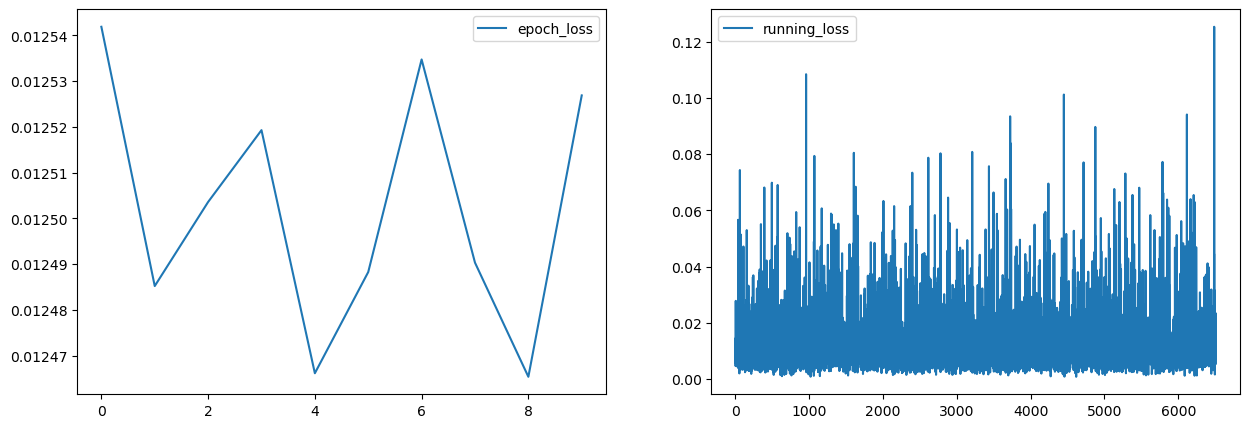

In [24]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

epoch_loss.plot(
    y = 0,
    label = "epoch_loss",
    ax=ax[0]
)

running_loss.plot(
    y = 0,
    label = "running_loss",
    ax=ax[1]
)

In [25]:
# model_name = f"test_LSTNet-E{epochs}"
# model_path = rf"saved_models\{model_name}.pth"
# torch.save(model.state_dict(), model_path)

In [46]:
# model_name = f"test_LSTNet-E{epochs}"
# model_path = f"{model_name}.pth"
model = LSTNet()
model.load_state_dict(torch.load(model_path))
model.eval()

LSTNet(
  (dropout): Dropout(p=0.2, inplace=False)
  (conv1): Conv2d(1, 32, kernel_size=(7, 5), stride=(1, 1))
  (recc1): GRU(32, 64, batch_first=True)
  (output): Linear(in_features=176, out_features=1, bias=True)
  (ar): Linear(in_features=7, out_features=1, bias=True)
)

# Prediction

In [47]:
min_cols = [col for col in train_data.columns if 'min' in col]
min_values = {col:train_data[col].unique()[0] for col in min_cols}

max_cols = [col for col in train_data.columns if 'max' in col]
max_values = {col:train_data[col].unique()[0] for col in max_cols}

print(min_values)
print(max_values)

{'pm2.5_min': 1.0, 'amb_temp_min': 8.1, 'ch4_min': 1.6, 'co_min': 0.05, 'nmhc_min': -0.03}
{'pm2.5_max': 85.0, 'amb_temp_max': 37.3, 'ch4_max': 3.0, 'co_max': 4.02, 'nmhc_max': 2.01}


In [48]:
test_data = pm25_df.iloc[int(len(pm25_df)*train_split):,:]
print(f"All data length:{len(pm25_df)} \nTrain data length:{len(test_data)}")
test_data.head()

All data length:8760 
Train data length:3504


,siteengname,pm2.5,amb_temp,ch4,co,nmhc,read_time
399457,Banqiao,9.0,29.8,1.8,0.18,0.05,2018-08-08 00:00:00
399533,Banqiao,7.0,29.8,1.8,0.15,0.07,2018-08-08 01:00:00
399609,Banqiao,7.0,29.6,1.8,0.15,0.13,2018-08-08 02:00:00
399685,Banqiao,7.0,29.3,1.9,0.15,0.15,2018-08-08 03:00:00
399761,Banqiao,4.0,28.9,1.9,0.15,0.16,2018-08-08 04:00:00


In [49]:
test_data = min_max_df_norm(test_data)
test_min_pm, test_max_pm = test_data["pm2.5"].min(), test_data["pm2.5"].max()

In [50]:
test_dataset = MarketDataset(test_data, history_len=history_len)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [51]:
for i, batch in tqdm(enumerate(test_data_loader, start=1),leave=False, total=len(test_data_loader)):
    X, Y = batch
    Y_pred = model(X).detach().numpy()
    if i == 1:
        predictions = Y_pred
    else:
        predictions = np.concatenate((predictions, Y_pred), axis=0)

predictions = predictions * (test_max_pm - test_min_pm) + test_min_pm

columns = ['pm2.5']
predictions = pd.DataFrame(predictions, columns=columns)
predictions['read_time'] = test_data.reset_index()['read_time']
print(predictions.shape)
predictions.head()

  0%|          | 0/432 [00:00<?, ?it/s]

(3456, 2)


,pm2.5,read_time
0,18.561272,2018-08-08 00:00:00
1,17.413353,2018-08-08 01:00:00
2,16.370777,2018-08-08 02:00:00
3,16.357515,2018-08-08 03:00:00
4,16.530182,2018-08-08 04:00:00


In [52]:
print(pm25_df.shape)
print(predictions.shape)

(8760, 7)
(3456, 2)


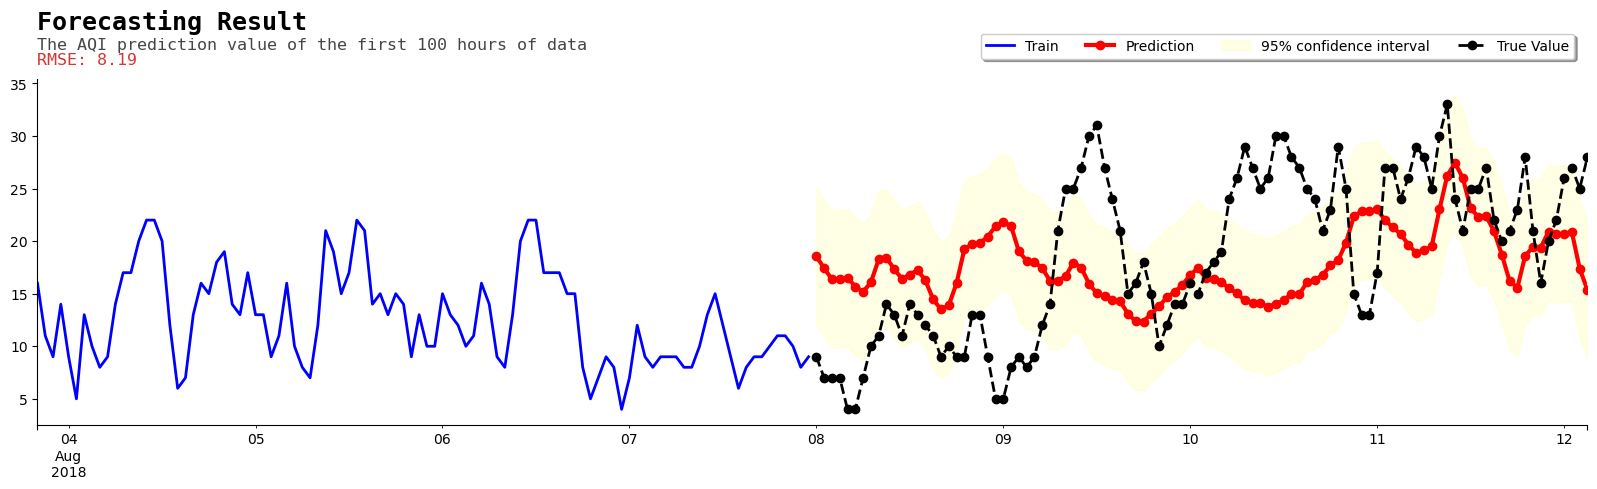

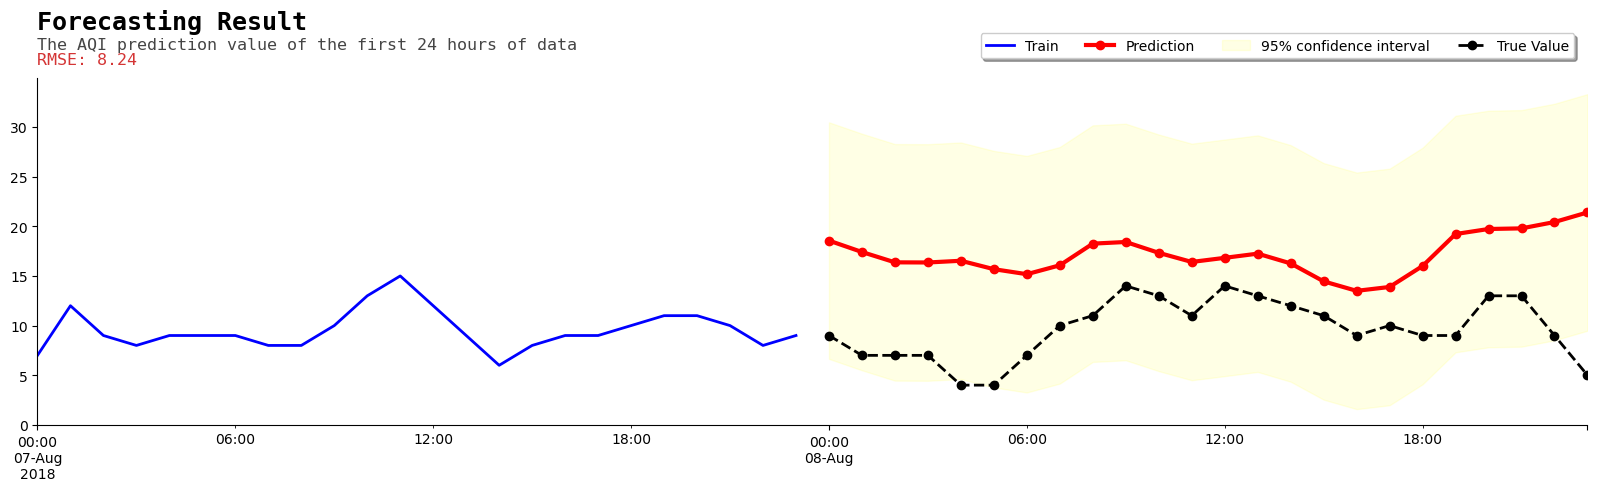

In [136]:
for length in [100, 24]:
    temp_train = train_data[['pm2.5', 'read_time']].reset_index().tail(length).reset_index().drop(columns=["index", "level_0"]).rename(columns={'pm2.5':'pm2.5_train'})
    temp_test = test_data[['pm2.5', 'read_time']].reset_index().head(length).reset_index().drop(columns=["index", "level_0"]).rename(columns={'pm2.5':'pm2.5_test'})
    temp_pred = predictions.head(length).rename(columns={'pm2.5':'pm2.5_prediction'})
    
    temp_pred_test = pd.merge(temp_pred, temp_test, on='read_time', how='inner')
    
    # Calculate MSE and RMSE
    temp_pred_test['squared_error'] = (temp_pred_test['pm2.5_test'] - temp_pred_test['pm2.5_prediction']) ** 2
    mse = temp_pred_test['squared_error'].mean()
    rmse = (temp_pred_test['squared_error'].mean())**.5

    fig, ax = plt.subplots(figsize = (20,5))
    
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    plt.xlabel("")
    
    temp_train.plot(
        x="read_time",
        y="pm2.5_train",
        ax=ax,
        label="Train",
        color="blue",
        lw=2
        )

    temp_pred_test.plot(
        x="read_time",
        y="pm2.5_prediction",
        ax=ax,
        label="Prediction",
        color="red",
        marker="o",
        lw=3
        )
    
    # Define the confidence interval
    ci = 0.95 * (temp_pred_test['squared_error'].std() / np.sqrt(len(temp_pred_test)))
    
    ax.fill_between(
        temp_pred_test.read_time.values, 
        (temp_pred_test["pm2.5_prediction"]-ci).to_numpy(), 
        (temp_pred_test["pm2.5_prediction"]+ci).to_numpy(), 
        color='yellow', alpha=0.1,
        label=r"95% confidence interval"
        )
    
    temp_pred_test.plot(
        x="read_time",
        y="pm2.5_test",
        linestyle='--',
        ax=ax,
        label="True Value",
        color="black",
        marker="o",
        lw=2
        )
    
    title = "<name:monospace, size:18><weight:bold>Forecasting Result</></>"
    flexitext(0, 1.20, title, va="top", ax=ax)

    subtitle = (f"<name:monospace, size:12, color:#454545>The AQI prediction value of the first {length} hours of data\n<color: #d43535>RMSE: {rmse:.2f}</></>")
    flexitext(0, 1.12, subtitle, va="top", ax=ax)
    
    # Shrink current axis's height by 10% on the bottom
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                    box.width, box.height * 0.9])

    # Put a legend below current axis
    ax.legend(
        loc='upper center', 
        bbox_to_anchor=(0.8, 1.15), # original (0.5, -0.05)
        fancybox=True, shadow=True, ncol=5
        )
    
    plt.xlabel(None)
    
    # plt.savefig(
    #     rf'images\prediction_result_{length}_hour.png',
    #     bbox_inches='tight'
    #     )

In [ ]:
# fig, ax = plt.subplots(figsize = (20,5))

# train_data.reset_index().plot(
#     x="read_time",
#     y="pm2.5",
#     ax=ax,
#     label="train",
#     color="blue",
#     lw=3
#     )

# predictions.plot(
#     x="read_time",
#     y="pm2.5",
#     ax=ax,
#     label="test",
#     color="red",
#     lw=3
#     )

# pm25_df.reset_index().plot(
#     x="read_time",
#     y="pm2.5",
#     linestyle='--',
#     ax=ax,
#     label="all-data",
#     color="black",
#     alpha=0.8,
#     lw=1
#     )